In [141]:
%matplotlib inline
import pylab
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from pysurvey.plot import setup, density, icolorbar

In [140]:
import  pysurvey.plot
reload(pysurvey.plot)

<module 'pysurvey.plot' from '/Users/ajmendez/research/clustering/pySurvey/pysurvey/plot.py'>

In [16]:
people = pd.read_json('/Users/ajmendez/data/okcupid/random_v2.json')

In [53]:
# Simple Markov chain generator.
# Modified from:
#   http://alexeymk.com/2012/07/15/weekend-hack--a-markov-baby-name-generator.html
WORD_SEP = ' '
class MarkovName(object):
    def __init__(self, names):
        '''names is a list sampling some population'''
        self.chain = defaultdict(list)
        self.mean_length = usernames.apply(len).mean()
        
        for name in names:
            proper_name = name.lower().strip()
            for first, second in zip(proper_name, proper_name[1:]):
                self.chain[first].append(second)
            self.chain[proper_name[-1]].append(WORD_SEP)
            self.chain[WORD_SEP].append(proper_name[0])
    
    def __call__(self):
        name = []
        current = WORD_SEP  # used to mark both first and last character
        while not (current == WORD_SEP and name):
            current = random.choice(self.chain[current])
            name.append(current)
        
        return ''.join(name).strip().capitalize()

usernames = people[people['match'] > 90]['username']
highmatch = MarkovName(usernames)
[highmatch() for i in range(20)]

[u'Hemeveetz',
 u'M',
 u'Micrsmyrm882',
 u'Atrlinstrirory4',
 u'Berag',
 u'Rilidelienaffoknisshr203den_cedy',
 u'H5100',
 u'Me16',
 u'Mali',
 u'Boflelllina-',
 u'Linaday',
 u'Ndz088',
 u'Jnik',
 u'Mooxle',
 u'Se',
 u'Kf001585ylin10',
 u'Lypy_all',
 u'Ewar2417',
 u'Sev',
 u'Auakutrh3']

<Container object of 10 artists>

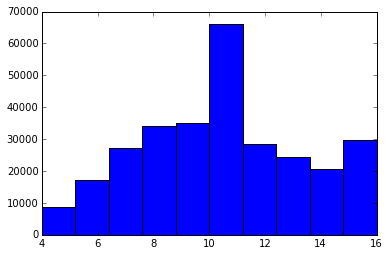

In [54]:
v,l = np.histogram(usernames.apply(len).as_matrix())
pylab.bar(left=l[:-1], width=np.diff(l),
          height=v)

In [70]:
from random import choice
import sys

def generateModel(text, order):
    model = {}
    for i in range(0, len(text) - order):
        fragment = text[i:i+order]
        next_letter = text[i+order]
        if fragment not in model:
            model[fragment] = {}
        if next_letter not in model[fragment]:
            model[fragment][next_letter] = 1
        else:
            model[fragment][next_letter] += 1
    return model

def getNextCharacter(model, fragment):
    letters = []
    for letter in model[fragment].keys():
        for times in range(0, model[fragment][letter]):
            letters.append(letter)
    return choice(letters)

def generateText(text, order, length):
    model = generateModel(text, order)
    currentFragment = text[0:order]
    output = []
    username = ''
    for i in range(0, length-order):
        newCharacter = getNextCharacter(model, currentFragment)
        username += newCharacter
        if newCharacter == ' ':
            output.append(username.strip())
            username = ''
        currentFragment = currentFragment[1:] + newCharacter
    return output

    
tmp = ' '.join(people[people['match'] > 90]['username'])
generateText(tmp, order=20, length=200)


[u'Leo82',
 u'AwakeMySoul14',
 u'BeerChic86',
 u'savvieinthecity',
 u'kumquatayers',
 u'allmytravels',
 u'sara_blue_',
 u'FreeSweetnWitty',
 u'boomer0811',
 u'lilleea',
 u'SuperMaryL',
 u'sailingtori',
 u'marg0x',
 u'theatregirlnyc',
 u'FroGlass']

In [73]:
tmp = ' '.join(people[(people['match'] > 40)  & (people['match'] < 70) ]['username'])
print len(tmp)
generateText(tmp, order=20, length=200)

1160322


[u'atemomma04',
 u'Binksyboo',
 u'MsClassyDiva',
 u'sammie1209',
 u'Chelles1124',
 u'curylikedaspice',
 u'lavishpurple',
 u'elamay77',
 u'CMidge87',
 u'HazelHope82',
 u'Chasingfaith7',
 u'Sudden88',
 u'luvlil8di',
 u'HopemarieB',
 u'lovenliving',
 u'J4lVl13']

In [75]:
import string

In [83]:
def make_words(n=5):
    words = people[(people['match'] > 40)  & (people['match'] < 70) ]['username']
    words = people[(people['match'] > 90) ]['username']
#     words = [w for w in words 
#              if all([c in string.ascii_lowercase for c in w])]
    words = ["^" + w + "$" for w in words if w != ""]

    # construct a discrete-time markov chain of n-grams
    n = 5 # this is the "n" in n-grams, try adjusting this for different results
    transitions = defaultdict(lambda: defaultdict(float))
    for word in words:
        if len(word) >= n:
            transitions[""][word[:n]] += 1.0
        for i in range(len(word) - n):
            gram = word[i : i + n]
            next = word[i + 1 : i + n + 1]
            transitions[gram][next] += 1.0

    # normalize the probabilities
    for gram in transitions:
        total = sum([transitions[gram][next] for next in transitions[gram]])
        for next in transitions[gram]:
            transitions[gram][next] /= total
    return words, transitions

# sample a probability mass function (dict from elements to probabilities)
def sample(pmf):
    sample = random.random()
    cdf = 0.0
    for e in pmf:
        cdf += pmf[e]
        if cdf >= sample:
            return e
    return random.choice(pmf.keys())

# generate a word according to the markov chain
def gen_word(n=5):
    # start with a prefix
    word = sample(transitions[""])
    
    # wait until the markov chain adds a terminator to the word
    while word[-1] != "$":
        # append a new letter chosen according to the markov chain
        gram = word[-n:]
        if gram in transitions:
            word += sample(transitions[gram])[-1:]
        else:
            word += choice(ascii_lowercase + "$")
        
        # optional: allow multi-word domains
        if word[-1] == "$" and random.random() > 0.7 and len(word) < 8:
            word += sample(transitions[""])
    
    # remove the boundary markers and return the word
    return word.replace("^", "").replace("$", "")

words, transitions = make_words()
[gen_word() for i in range(20)]

[u'curido',
 u'HeyCsiga',
 u'aiaiii',
 u'sarah',
 u'bluerose',
 u'tall_italian1',
 u'MNyogiRL',
 u'kingsloverlovr',
 u'BellicoseBanter',
 u'a_mackenzieL87',
 u'kreatyvgirl1211',
 u'ahoyitssara',
 u'quirkyAudra',
 u'bluedanio',
 u'oforamusings',
 u'FebruaryWithTheDonsk1206',
 u'courtney',
 u'rosequartzdust',
 u'dancer13',
 u'Tyj234']

In [82]:
words, transitions = make_words()
[gen_word() for i in range(20)]

[u'ThursdayFae',
 u'seattle_Abby',
 u'redgirl14103',
 u'lxxol',
 u'Kparksmay',
 u'pearpril',
 u'chaezie',
 u'page3babe',
 u'Bamadiz',
 u'Sonia_Celestelm60',
 u'Littleladylemon12',
 u'Elle_bluestar2388',
 u'jcghbcg',
 u'binbinlady86',
 u'sweetchubbyD',
 u'luv_fishtar',
 u'jazzyjoy',
 u'jenniferwendyb223',
 u'sweetCoral-A',
 u'veronica6789']